# overview
以下notebookを参考に、重複画像を除外したdataframを作成する　　
https://www.kaggle.com/schulta/petfinder-identify-duplicates-and-share-findings/notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import itertools
import collections

from PIL import Image
import cv2
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import torch

import imagehash 
# 画像の類似度を雰囲気（輝度分布とか）から判定し、
# 指標化（ちょっと違うと思うけどハッシュ化）してくれるモジュール
# 今回はこいつが主役
# 日本語記事：https://qiita.com/mamo3gr/items/b93545a0346d8731f03c

import matplotlib.pyplot as plt


train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')

In [2]:
def run():

    # hash化関数ズ
    funcs = [
        imagehash.average_hash, # シンプルに輝度の平均値からハッシュ化
        imagehash.phash, # 難しくてﾜｶﾗﾝ
        imagehash.dhash, # 難しくてﾜｶﾗﾝ
        imagehash.whash, # 難しくてﾜｶﾗﾝ
    ]

    petids = []
    hashes = []
    for path in tqdm(glob.glob('../input/petfinder-pawpularity-score/train/*.jpg')):

        image = Image.open(path)
        imageid = path.split('/')[-1].split('.')[0]

        petids.append(imageid)
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))
        # 一枚の画像に対して、関数ズをリスト内包表記で適用する
        # torchのtransformerチックな書き方
        # hash = 64bitなので、64×４で２５６要素数の1次元配列にしている
        # このハッシュ情報も特徴量として学習させられないでしょうか

    return petids, np.array(hashes)

%time petids, hashes_all = run()



CPU times: user 7min 18s, sys: 9.78 s, total: 7min 28s
Wall time: 8min 27s


In [3]:
print(hashes_all.shape)
print(hashes_all[0])

(9945, 256)
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False  True  True  True  True False False False False
  True  True  True False False  True  True  True  True  True False False
 False False  True  True  True  True False False False False False  True
 False False False False False  True  True  True False False  True False
  True  True  True  True  True  True  True False False False  True False
  True  True False False  True False False False  True False False  True
  True  True False  True False False  True  True  True  True  True False
  True False  True  True False False  True False  True False False  True
 False False  True  True  True False  True False  True False  True  True
 False  True False False  True False False False  True  True False  True
  True  True False False  True False False False False False False False
  True  True False False False False  True  True  True False False False
  True  True False  True  True False Fa

boolen値で入ってる

In [4]:
hashes_all = torch.Tensor(hashes_all.astype(int))

In [5]:
%time sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

CPU times: user 3min 30s, sys: 1.2 s, total: 3min 31s
Wall time: 27.2 s


In [6]:
print(sims.shape)
# 縦、横：画像枚数

(9945, 9945)


In [7]:
print(sims)
# 値：画像同士の類似度（０−１）
# (一致したハッシュの数)/(全ハッシュ数)

[[1.         0.51953125 0.58203125 ... 0.4375     0.4921875  0.59765625]
 [0.51953125 1.         0.4765625  ... 0.52734375 0.47265625 0.5078125 ]
 [0.58203125 0.4765625  1.         ... 0.48828125 0.62890625 0.671875  ]
 ...
 [0.4375     0.52734375 0.48828125 ... 1.         0.5078125  0.41015625]
 [0.4921875  0.47265625 0.62890625 ... 0.5078125  1.         0.58203125]
 [0.59765625 0.5078125  0.671875   ... 0.41015625 0.58203125 1.        ]]


In [8]:
def show_pairs(lower_sim=0.0, upper_sim=1.0, max_shown=100):
    indices1 = np.where((sims > lower_sim) & (sims <= upper_sim))
    indices2 = np.where(indices1[0] != indices1[1])
    dups = {tuple(sorted([petids[index1], petids[index2]])): sims[index1, index2] 
                for index1, index2 in zip(indices1[0][indices2], indices1[1][indices2])}
    print('Found %d pairs' % len(dups))
    
    cnt = 1
    for (id1, id2), sim in dups.items():
        path1 = f'../input/petfinder-pawpularity-score/train/{id1}.jpg'
        path2 = f'../input/petfinder-pawpularity-score/train/{id2}.jpg'
        pawp1 = train[train['Id'] == id1]['Pawpularity'].iloc[-1]
        pawp2 = train[train['Id'] == id2]['Pawpularity'].iloc[-1]

        image1 = cv2.imread(path1)
        image2 = cv2.imread(path2)
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(12, 6)
        axes[0].title.set_text(f'Pawpularity: {pawp1} \n ID: {id1}')
        axes[0].imshow(image1)
        axes[1].title.set_text(f'Pawpularity: {pawp2} \n ID: {id2}')
        axes[1].imshow(image2)
        fig.suptitle(f'Simularity: {sim}')
        plt.show()
        
        if cnt >= max_shown:
            break
        
        cnt += 1
    
    return dups

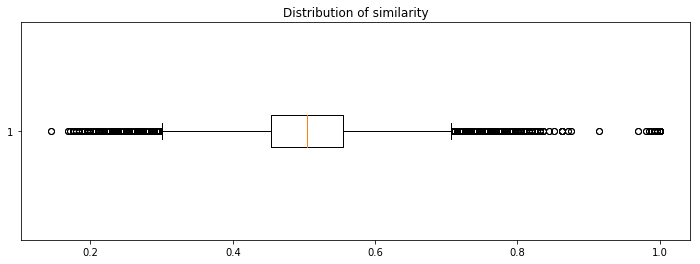

In [9]:
def offdiagonal(X, axis1, axis2):
    X = np.moveaxis(X, (axis1, axis2), (-2, -1))
    *s, n, _ = X.shape
    X = X.reshape(*s, n*n)[..., :-1].reshape(*s, n-1, n+1)[..., 1:].reshape(*s, n, n-1)
    return np.moveaxis(X, (-2, -1), (axis1, axis2))


plt.figure(figsize=(12, 4))
plt.title('Distribution of similarity')
plt.boxplot(offdiagonal(sims, 0, 1).flatten(), vert=False);

1あたりにクラスターがあって、おそらくそれが重複画像
って言ってた

Found 60 pairs


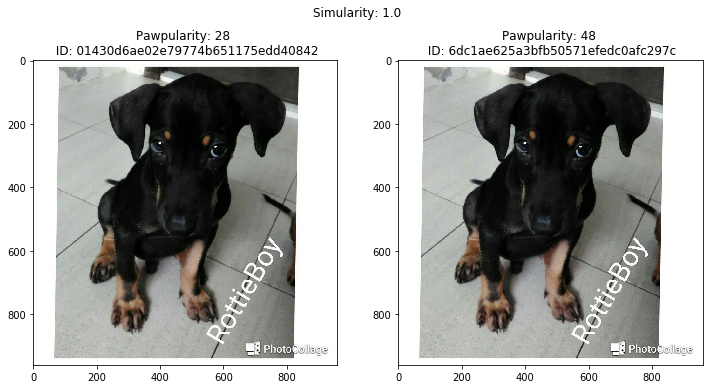

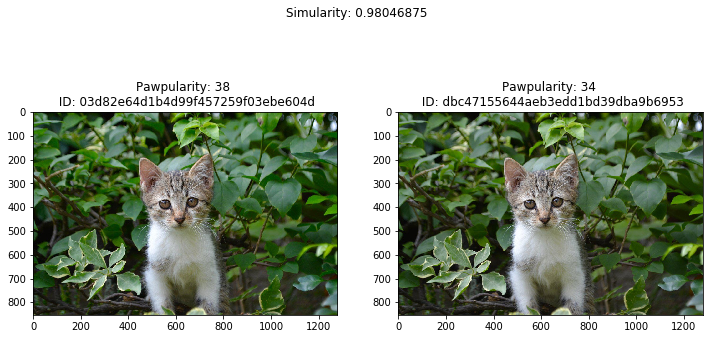

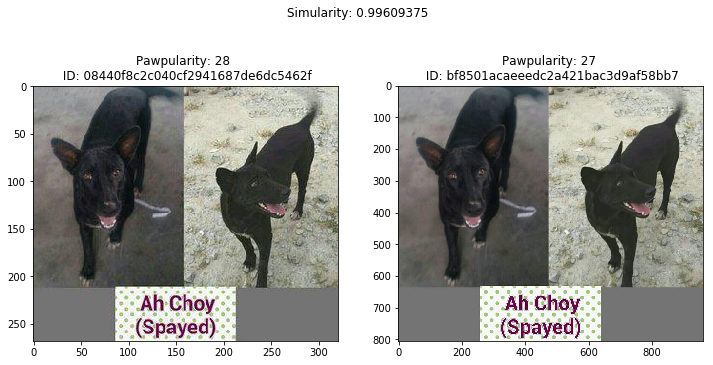

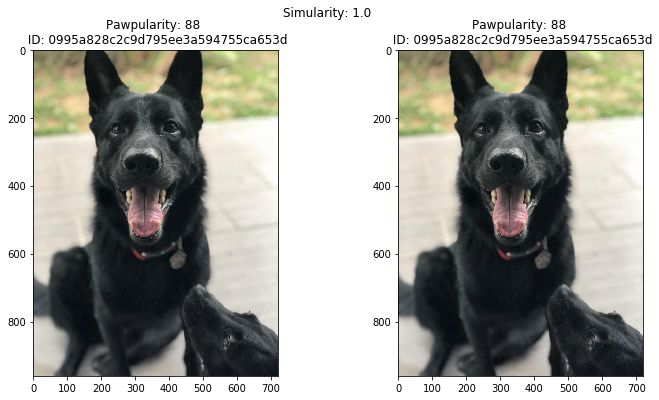

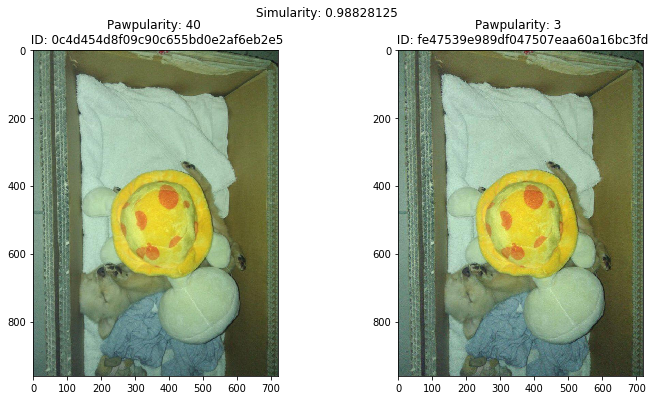

In [10]:
dups_90_00 = show_pairs(0.90, 1.0, max_shown=5)

Found 6 pairs


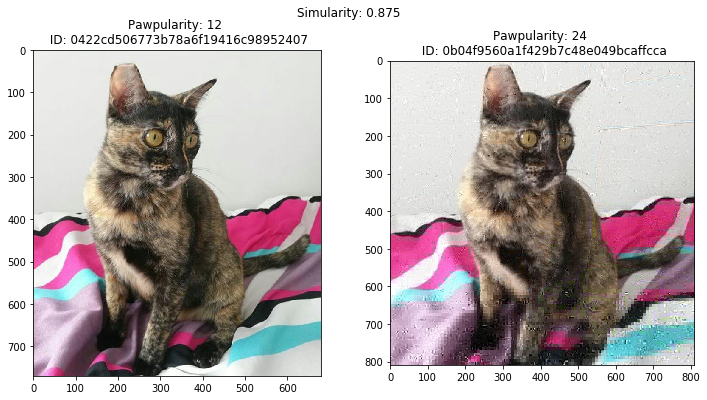

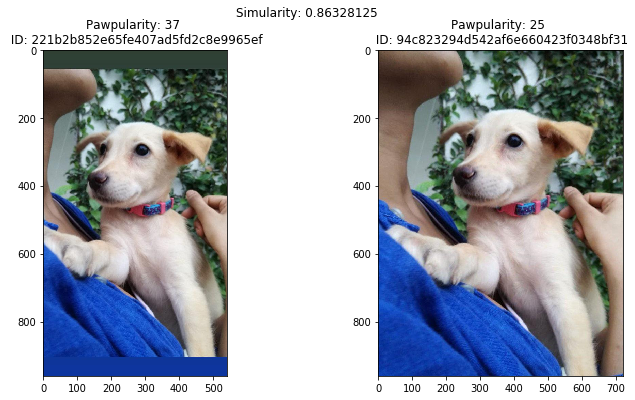

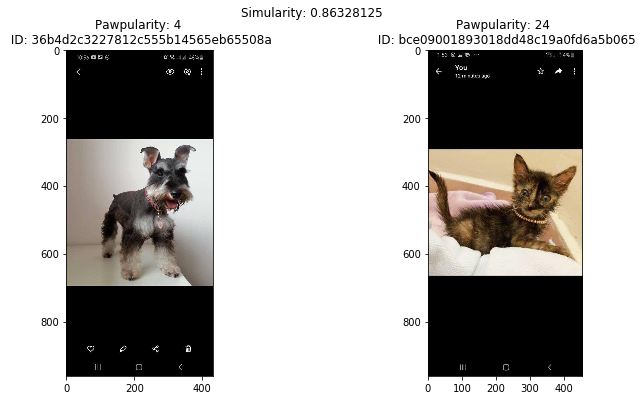

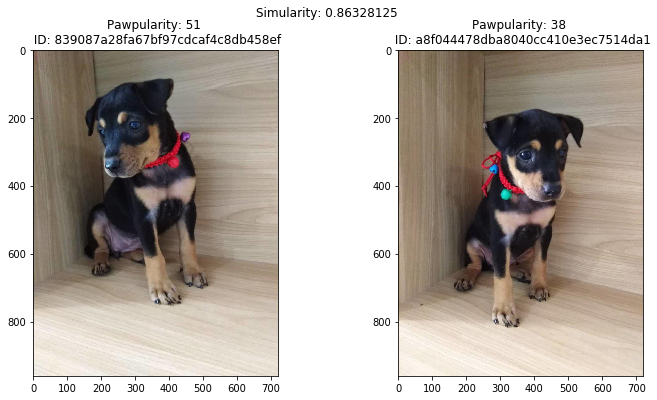

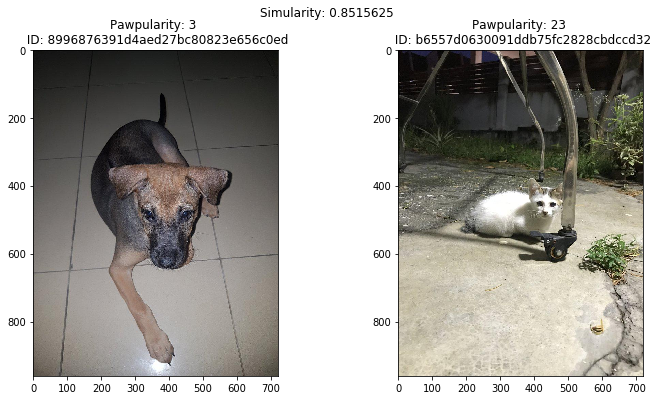

In [11]:
dups_85_90 = show_pairs(0.85, 0.9, max_shown=5)

Found 170 pairs


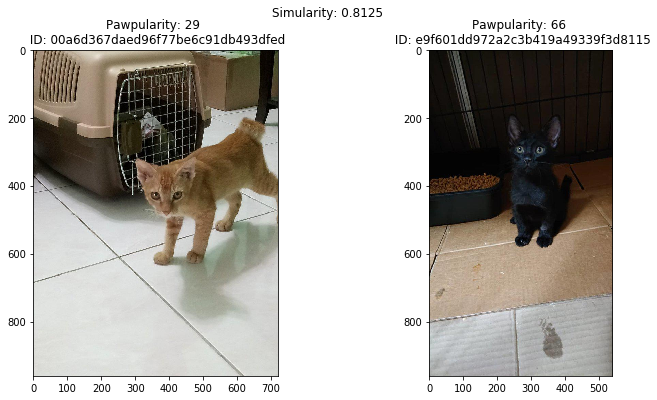

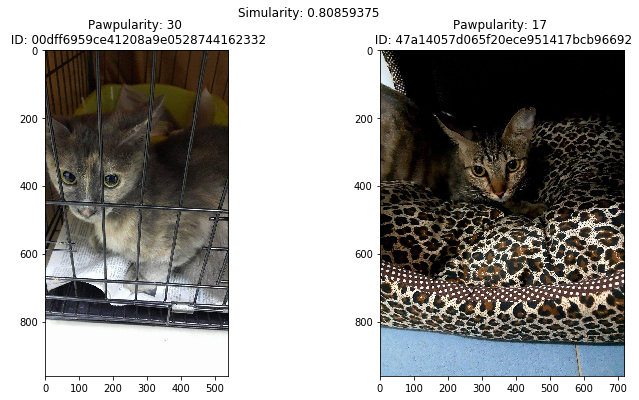

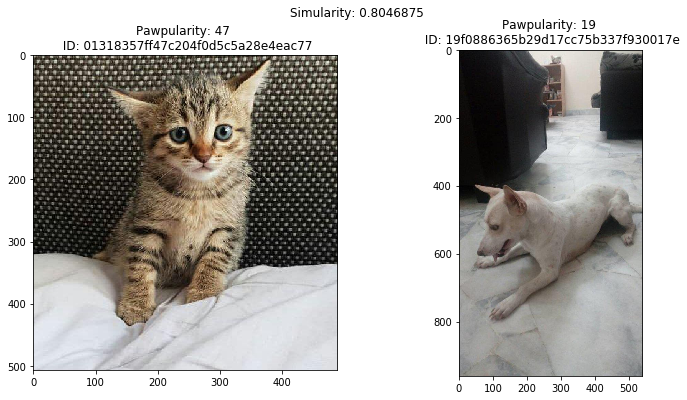

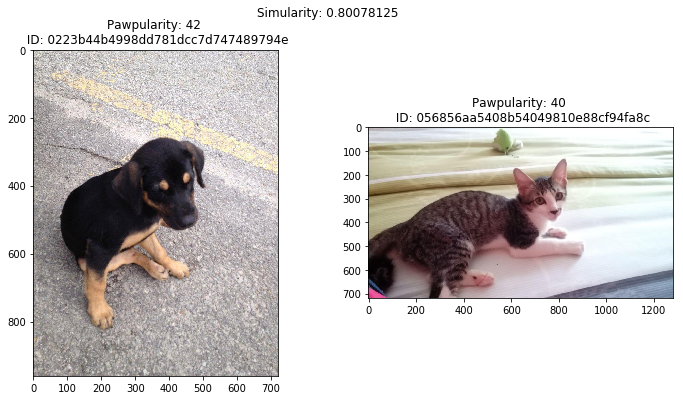

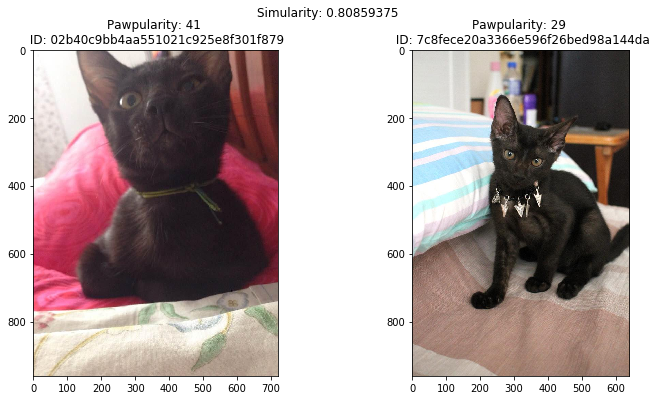

In [12]:
dups_80_85 = show_pairs(0.80, 0.85, max_shown=5)

In [13]:
print(dups_90_00)

{('01430d6ae02e79774b651175edd40842', '6dc1ae625a3bfb50571efedc0afc297c'): 1.0, ('03d82e64d1b4d99f457259f03ebe604d', 'dbc47155644aeb3edd1bd39dba9b6953'): 0.98046875, ('08440f8c2c040cf2941687de6dc5462f', 'bf8501acaeeedc2a421bac3d9af58bb7'): 0.99609375, ('0995a828c2c9d795ee3a594755ca653d', '0995a828c2c9d795ee3a594755ca653d'): 1.0, ('0c4d454d8f09c90c655bd0e2af6eb2e5', 'fe47539e989df047507eaa60a16bc3fd'): 0.98828125, ('1059231cf2948216fcc2ac6afb4f8db8', 'bca6811ee0a78bdcc41b659624608125'): 0.96875, ('13aff9dd79e84f2c220a9ab587897fe9', '13aff9dd79e84f2c220a9ab587897fe9'): 1.0, ('13d215b4c71c3dc603cd13fc3ec80181', '373c763f5218610e9b3f82b12ada8ae5'): 0.99609375, ('16d8e12207ede187e65ab45d7def117b', '16d8e12207ede187e65ab45d7def117b'): 1.0, ('1feb99c2a4cac3f3c4f8a4510421d6f5', '264845a4236bc9b95123dde3fb809a88'): 1.0, ('2b737750362ef6b31068c4a4194909ed', '41c85c2c974cc15ca77f5ababb652f84'): 0.98828125, ('321ca63d9b9d26f5b925f228831b1737', '321ca63d9b9d26f5b925f228831b1737'): 1.0, ('3447ff5b30

dictになってて、key=(id1,id2),value=類似度

# データフレームの作成
類似度0.85-1.0を除外する。

In [14]:
ids1_90_00 = np.array(list(dups_90_00.keys()))[:, 0]
ids1_85_90 = np.array(list(dups_85_90.keys()))[:, 0]
ids1 = np.concatenate([ids1_90_00 ,ids1_85_90])

ids2_90_00 = np.array(list(dups_90_00.keys()))[:, 1]
ids2_85_90 = np.array(list(dups_85_90.keys()))[:, 1]
ids2 = np.concatenate([ids2_90_00 ,ids2_85_90])

In [15]:
train_new = train[~train["Id"].isin(ids2)] # "~"はビット反転らしい,つまりないやつを抽出
train_new = train_new.reset_index(drop=True)
train_new = train_new.astype(int,errors="ignore")

train_new.to_csv('../input/custom_df/train_excDup_85_00.csv', 
                 index=False)

In [16]:
num_origin = len(train)
num_new = len(train_new)
print(f'元画像数：　{num_origin}')
print(f'類似画像の除外後の画像数{num_new}')
print(f'除外率{(1- num_new/num_origin) * 100:.2}%')

元画像数：　9912
類似画像の除外後の画像数9846
除外率0.67%


0.6%が除外された、てっきりもっとあるんかと　思ってた